<a href="https://colab.research.google.com/github/ayushs0911/Projects/blob/main/YOLO_from_Scratch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import seaborn as sns### visualizations
import matplotlib.pyplot as plt### plotting bar chart
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET
import os
import shutil
import cv2
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal

# Dataset download

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d huanghanchina/pascal-voc-2012

mkdir: cannot create directory ‘/root/.kaggle’: File exists
pascal-voc-2012.zip: Skipping, found more recently modified local copy (use --force to force download)


Un-Comment next cell for downloading dataset. 

In [ ]:
# !unzip "/content/pascal-voc-2012.zip" -d "/content/dataset/"

In [ ]:
val_list=['2007_000027.jpg','2007_000032.jpg','2007_000033.jpg','2007_000039.jpg','2007_000042.jpg','2007_000061.jpg',
          '2007_000063.jpg','2007_000068.jpg','2007_000121.jpg','2007_000123.jpg','2007_000129.jpg','2007_000170.jpg',
          '2007_000175.jpg','2007_000187.jpg','2007_000241.jpg','2007_000243.jpg','2007_000250.jpg','2007_000256.jpg',
          '2007_000272.jpg','2007_000323.jpg','2007_000332.jpg','2007_000333.jpg','2007_000346.jpg','2007_000363.jpg',
          '2007_000364.jpg','2007_000392.jpg','2007_000423.jpg','2007_000452.jpg','2007_000464.jpg','2007_000480.jpg',
          '2007_000491.jpg','2007_000504.jpg','2007_000515.jpg','2007_000528.jpg','2007_000529.jpg','2007_000549.jpg',
          '2007_000559.jpg','2007_000572.jpg','2007_000584.jpg','2007_000629.jpg','2007_000636.jpg','2007_000645.jpg',
          '2007_000648.jpg','2007_000661.jpg','2007_000663.jpg','2007_000664.jpg','2007_000676.jpg','2007_000713.jpg',
          '2007_000720.jpg','2007_000727.jpg','2007_000733.jpg','2007_000738.jpg','2007_000762.jpg','2007_000768.jpg',
          '2007_000783.jpg','2007_000793.jpg','2007_000799.jpg','2007_000804.jpg','2007_000807.jpg','2007_000822.jpg',
          '2007_001299.jpg','2007_001311.jpg','2007_001321.jpg','2007_001340.jpg']

In [ ]:
train_images = "/content/dataset/VOC2012/JPEGImages/"
train_maps = "/content/dataset/VOC2012/Annotations/"

val_images='/content/dataset/VOC2012/ValJPEGImages/'
val_maps='/content/dataset/VOC2012/ValAnnotations/'

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

B=2 # bounding boxes 
N_CLASSES=len(classes)
H,W =224,224
SPLIT_SIZE=H//32
N_EPOCHS=135
BATCH_SIZE=32

In [ ]:
!mkdir /content/dataset/VOC2012/ValJPEGImages/
!mkdir /content/dataset/VOC2012/ValAnnotations/

mkdir: cannot create directory ‘/content/dataset/VOC2012/ValJPEGImages/’: File exists
mkdir: cannot create directory ‘/content/dataset/VOC2012/ValAnnotations/’: File exists


In [ ]:
for name in val_list:
  shutil.move(train_maps+name[:-3]+"xml", val_maps+name[:-3]+"xml")

In [ ]:
for name in val_list:
  shutil.move(train_images+name, val_images+name)

# Data Prepration 

Function `preprocess_xml` takes input a filename. This function processes an XML file using the **ElementTree module** in Python, extracts the bounding box coordinates and class labels for objects in the image, and **returns the bounding boxes as a tensor**.

- `tree = ET.parse(filename)`, `root = tree.getroot()`, and `size_tree = root.find('size')` create an ElementTree object by parsing the XML file, retrieve the root element of the XML tree, and retrieve the `size` element in the XML file.

-  `height = float(size_tree.find('height').text)`, `width = float(size_tree.find('width').text)`, and `depth = float(size_tree.find('depth').text)` retrieve the `height`, `width`, and `depth` attributes of the `size` element. These attributes define the dimensions of the image.

- The `bounding_boxes` list is initialized as an empty list. 
- The `for` loop iterates over each `object` element using the `root.findall('object')` method. The `for` loop then iterates over each `bndbox` element in the `object` element using the `object_tree.iter('bndbox')` method.

- Within the `for` loop, the `xmin`, `ymin`, `xmax`, and `ymax` attributes of the `bndbox` element are retrieved using the `bounding_box.find()` method 

The `class_name` is retrieved using the `object_tree.find('name').text` method.

The bounding box is then normalized and converted to a list `[xc, yc, w, h, class_id]`. 
- `xc` and `yc` are the normalized coordinates of the center of the bounding box. 
- `w` and `h` are the normalized width and height of the bounding box.

In [ ]:
def preprocess_xml(filename):
  tree = ET.parse(filename)
  root = tree.getroot()
  size_tree = root.find('size')
  height = float(size_tree.find('height').text)
  width = float(size_tree.find('width').text)
  depth = float(size_tree.find('depth').text)
  
  bounding_boxes = []
  for object_tree in root.findall('object'):
    for bounding_box in object_tree.iter('bndbox'):
      xmin = (float(bounding_box.find('xmin').text))
      ymin = (float(bounding_box.find('ymin').text))
      xmax = (float(bounding_box.find('xmax').text))
      ymax = (float(bounding_box.find('ymax').text))

      # print(xmin, ymin, xmax, ymax)
      break
    class_name = object_tree.find('name').text
    class_dict = {classes[i]:i for i in range(len(classes))}
    bounding_box = [
        (xmin+xmax)/(2*width),
        (ymin+ymax)/(2*height),
        (xmax-xmin)/width,
        (ymax-ymin)/height,
        class_dict[class_name]]
    bounding_boxes.append(bounding_box)
  return tf.convert_to_tensor(bounding_boxes)

In [ ]:
# preprocess_xml("/content/dataset/VOC2012/Annotations/2007_000078.xml")

This code defines a function called `generate_output` that takes in a tensor `bounding_boxes` and returns a tensor `output_label`. The purpose of this function is to generate the output label for an object detection task, given the bounding box coordinates of the objects in an image.

The function first creates an empty array `output_label` of size `(SPLIT_SIZE, SPLIT_SIZE, N_CLASSES+5)`, where `SPLIT_SIZE` is the number of grid cells used to divide the image and `N_CLASSES` is the number of object classes to be detected. The `+5` term represents the predicted bounding box coordinates and objectness score.

The function then iterates over each bounding box in the `bounding_boxes` tensor, calculates the corresponding grid cell index, and sets the values in the output label tensor accordingly. The first five values represent the predicted bounding box coordinates (x, y, width, height) and the objectness score. The sixth value onwards represents the class probabilities.

Overall, this function is a crucial step in the object detection pipeline, as it generates the output label that is used to train the model.

In [ ]:
def generate_output(bounding_boxes):
  output_label=np.zeros((SPLIT_SIZE,SPLIT_SIZE,N_CLASSES+5))
  for b in range(len(bounding_boxes)):
    grid_x=bounding_boxes[...,b,0]*SPLIT_SIZE
    grid_y=bounding_boxes[...,b,1]*SPLIT_SIZE
    i=int(grid_x)
    j=int(grid_y)

    output_label[i,j,0:5]=[1.,grid_x%1,grid_y%1,bounding_boxes[...,b,2],bounding_boxes[...,b,3]]
    output_label[i,j,5+int(bounding_boxes[...,b,4])]=1.

  return tf.convert_to_tensor(output_label,tf.float32)

In [ ]:
# generate_output(preprocess_xml("/content/dataset/VOC2012/Annotations/2007_000032.xml"))[2][2]

In [ ]:
im_paths = []
xml_paths = []

val_im_paths = []
val_xml_paths = []

for i in os.listdir(train_maps):
  im_paths.append(train_images + i[:-3]+'jpg')
  xml_paths.append(train_maps + i)

for i in os.listdir(val_maps):

  val_im_paths.append(val_images + i[:-3]+'jpg')
  val_xml_paths.append(val_maps + i)

print(len(im_paths), len(xml_paths))
print(len(val_im_paths), len(val_xml_paths))

17061 17061
64 64


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((im_paths, xml_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_im_paths, val_xml_paths))

In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValJPEGImages/2007_000762.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValAnnotations/2007_000762.xml'>)


`get_imbboxes` that takes in two arguments, `im_path` and `xml_path`, and  returns a tuple containing two values, `img` and `bboxes`.

1st line reads in the image file using `tf.io.read_file()` and then decodes it using `tf.io.decode_jpeg()`. Then resized using `tf.image.resize()` to the specified height `H` and width `W`, and casted to a float32 data type.

`tf.numpy_function()` call the `preprocess_xml()` function, which parses the XML file and extracts the bounding boxes from it. The resulting `bboxes` tensor is returned along with the resized image tensor `img` in a tuple.

In [ ]:
def get_imbboxes(im_path, xml_path):
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(tf.image.resize(img, size = [H,W]), dtype = tf.float32)

  bboxes = tf.numpy_function(func = preprocess_xml,
                             inp = [xml_path],
                             Tout = tf.float32)
  return img, bboxes

In [ ]:
train_dataset = train_dataset.map(get_imbboxes)
val_dataset = val_dataset.map(get_imbboxes)

In [ ]:
for i, j in train_dataset.skip(28):
  print(i.shape, j)
  break

(224, 224, 3) tf.Tensor([[0.624      0.27333334 0.612      0.52       7.        ]], shape=(1, 5), dtype=float32)


#Data Augmentation 


Using the `albumentations` library to define a set of image augmentations to be applied during training. 

- `A.Resize(H,W)`: resizes the image to the height and width specified by `H` and `W` respectively.
- `A.RandomCrop(...)`: randomly crops a rectangular portion of the image. The `width` and `height` parameters specify the size of the crop, which is randomly sampled within certain ranges. 
  - The `p` parameter specifies the probability of applying the transformation.
- `A.RandomScale(...)`: randomly scales the image. 
  - The `scale_limit` parameter specifies the range of scaling factors to sample from, and 
  - the `interpolation` parameter specifies the method to use for interpolation.  
- `A.HorizontalFlip(...)`: flips the image horizontally.  
- `A.Resize(H,W)`: resizes the image to the height and width specified by `H` and `W` respectively.

The `bbox_params` parameter specifies the parameters for handling the bounding boxes associated with the objects in the image. The `format` parameter specifies the format of the bounding box coordinates (in this case, YOLO format). 

In [ ]:
transforms = A.Compose([
    A.Resize(H,W), 
    A.RandomCrop(
        width = np.random.randint(int(0.9*W), W),
        height = np.random.randint(int(0.9*H),H), p = 0.5),
    A.RandomScale(scale_limit = 0.1, interpolation = cv2.INTER_LANCZOS4, p = 0.5),
    A.HorizontalFlip(p =0.5),
    A.Resize(H,W),
], bbox_params = A.BboxParams(format = "yolo", ))

In [ ]:
def aug_albument(image, bboxes):
  augmented = transforms(image = image, 
                         bboxes = bboxes)
  return [tf.convert_to_tensor(augmented['image'], dtype = tf.float32),
          tf.convert_to_tensor(augmented['bboxes'], dtype = tf.float32)]

In [ ]:
def process_data(image, bboxes):
  aug = tf.numpy_function(func = aug_albument, 
                          inp = [image, bboxes],
                          Tout = (tf.float32, tf.float32))
  return aug[0], aug[1]

In [ ]:
train_dataset = train_dataset.map(process_data)

In [ ]:
def preprocess_augment(img, y):
  img = tf.image.random_brightness(img, max_delta = 50.)
  img = tf.image.random_saturation(img, lower = 0.5, upper = 1.5)
  img = tf.image.random_contrast(img, lower = 0.5, upper = 1.5)

  img = tf.clip_by_value(img, 0, 255)

  labels = tf.numpy_function(func = generate_output,
                             inp = [y], 
                             Tout = (tf.float32))
  return img, labels

In [ ]:
def preprocess(img, y):
  img = tf.cast(tf.image.resize(img, size = [H,W]), dtype = tf.float32)
  labels = tf.numpy_function(
      func = generate_output, 
      inp = [y], 
      Tout = (tf.float32)
  )
  return img, labels

In [ ]:
train_dataset = train_dataset.map(preprocess_augment)
val_dataset = val_dataset.map(preprocess)

In [ ]:
train_dataset = (train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

# Model

In [ ]:
NUM_FILTERS = 512 
OUTPUT_DIM = N_CLASSES + 5*B  

In [ ]:
base_model=tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
base_model.trainable=False

In [ ]:
model=tf.keras.Sequential([    
  base_model,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),
  
  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Dropout(0.5),
  
  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,activation='sigmoid'),
  
  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 512)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                      

This function computes the intersection over union (IoU) between two sets of bounding boxes represented by the input tensors `boxes1` and `boxes2`. The IoU is a commonly used evaluation metric in object detection and image segmentation tasks, which measures the overlap between two sets of bounding boxes.

First, the function transforms the input tensors `boxes1` and `boxes2` from their center coordinates and size representations to coordinates of the top-left and bottom-right corners of the boxes, using the formulas:

    x_min = x_center - width / 2.0
    y_min = y_center - height / 2.0
    x_max = x_center + width / 2.0
    y_max = y_center + height / 2.0

These coordinates are stacked into new tensors `boxes1_t` and `boxes2_t` using the `tf.stack` function.

Then, the function computes the coordinates of the top-left and bottom-right corners of the intersection between `boxes1_t` and `boxes2_t`, which are stored in tensors `lu` and `rd`, respectively. These are computed element-wise using `tf.maximum` and `tf.minimum` functions.

Next, the function computes the area of the intersection region `inter_square`, which is computed as the element-wise product of the width and height of `intersection`.

The area of the union region between `boxes1_t` and `boxes2_t` is computed as the sum of the areas of `boxes1` and `boxes2`, minus the area of the intersection `inter_square`, using the formula `square1 + square2 - inter_square`. A small value of `1e-10` is added to the denominator to avoid division by zero.

Finally, the IoU between `boxes1_t` and `boxes2_t` is computed as the ratio of the area of intersection `inter_square` to the area of the union region `union_square`, which is then clipped to the range `[0.0, 1.0]` using `tf.clip_by_value`. The resulting tensor is returned as the output of the function.

In [ ]:
def compute_iou(boxes1, boxes2):
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

In [ ]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

In [ ]:
def yolo_loss(y_true, y_pred):
  target = y_true[...,0]

  ###################### OBject Loss
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))
  
  rescaler = tf.where(target[:]==1)*SPLIT_SIZE
  upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)
  
  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)
  
  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2
  
  mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)
  
  y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))
  
  obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  
  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))

  ####################### For No object
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))
  
  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))
  
  no_object_loss = no_object_loss_1+no_object_loss_2

  ######################## For OBject class loss
  y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))
  class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

  class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                ,tf.cast(class_extract,dtype=tf.float32))

  ######################### For object bounding box loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
  centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))
  
  centre_loss = difference(centre_pred,centre_target)
    
  size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))
  
  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss+size_loss
  
  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32) 
  return loss

In [ ]:
checkpoint_filepath='/content/drive/MyDrive/Bang/yolo_efficientnet_b1_new.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def scheduler(epoch, lr):
  if epoch < 40:
    return 1e-3
  elif epoch>=40 and epoch<80:
    return 5e-4
  else:
    return 1e-4

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.compile(
  loss=yolo_loss,
  optimizer=Adam(1e-3),
)

In [ ]:
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=40,
  callbacks = [callback, 
               lr_callback]
)

Epoch 1/40
534/534 [==============================] - 193s 362ms/step - loss: 140.5217 - val_loss: 157.9310 - lr: 0.0010
Epoch 2/40
534/534 [==============================] - 191s 358ms/step - loss: 134.3264 - val_loss: 152.3115 - lr: 0.0010
Epoch 3/40
534/534 [==============================] - 209s 391ms/step - loss: 129.4317 - val_loss: 150.3799 - lr: 0.0010
Epoch 4/40
534/534 [==============================] - 195s 365ms/step - loss: 124.4120 - val_loss: 147.4566 - lr: 0.0010
Epoch 5/40
534/534 [==============================] - 192s 360ms/step - loss: 120.7486 - val_loss: 145.7665 - lr: 0.0010
Epoch 6/40
534/534 [==============================] - 197s 368ms/step - loss: 117.2720 - val_loss: 144.8615 - lr: 0.0010
Epoch 7/40
534/534 [==============================] - 190s 356ms/step - loss: 114.3385 - val_loss: 138.7827 - lr: 0.0010
Epoch 8/40
534/534 [==============================] - 190s 356ms/step - loss: 110.8902 - val_loss: 139.3898 - lr: 0.0010
Epoch 9/40
534/534 [============

KeyboardInterrupt: ignored

#Testing 

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
!mkdir outputs/

In [ ]:
VAL_PATH='/content/dataset/VOC2012/ValJPEGImages/'

Function named `model_test` that takes a filename as input and performs object detection on the image corresponding to that filename using a **pre-trained YOLOv3 model**. 

The function first reads the image from the given path, resizes it to the height and width defined by `H` and `W` variables respectively, and feeds it to the model for prediction. It sets a threshold value `THRESH` and extracts the predicted bounding boxes for all objects whose confidence scores are greater than or equal to this threshold.


The function then computes the coordinates of the final bounding boxes using the predicted coordinates and dimensions of the bounding boxes, and stores them along with the class labels and confidence scores in `final_boxes` and `final_scores` lists respectively. 

It applies non-maximum suppression to these boxes to eliminate overlapping boxes and keep only the most confident ones.

Finally, it draws rectangles around the selected boxes and displays the class labels and confidence scores on the image, and saves the resulting image to a file in the `/content/outputs` directory. If no object is detected in the image, the function prints a message stating the same.

In [ ]:
def model_test(filename):
  try:
    test_path=VAL_PATH+filename

    print(test_path)
    
    img=cv2.resize(cv2.imread(test_path),(H,W))

    image=tf.io.decode_jpeg(tf.io.read_file(test_path))
    image=tf.image.resize(image, [H,W])

    output=model.predict(np.expand_dims(image, axis = 0))

    THRESH=.25

    object_positions=tf.concat(
        [tf.where(output[...,0]>=THRESH),tf.where(output[...,5]>=THRESH)],axis=0)
    print(object_positions)
    selected_output=tf.gather_nd(output,object_positions)
    print(selected_output)
    final_boxes=[]
    final_scores=[]

    for i,pos in enumerate(object_positions):
      for j in range(2):      
        if selected_output[i][j*5]>THRESH:
          output_box=tf.cast(output[pos[0]][pos[1]][pos[2]][(j*5)+1:(j*5)+5],dtype=tf.float32)
          
          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])
          
          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H
          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])
    # print(final_scores)
    # print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)
    
    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]

    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
        score_threshold=float('-inf')
    )
    print(nms_output)

    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )
        
    cv2.imwrite('/content/outputs/'+filename[:-4]+'_det'+'.jpg',cv2.resize(img,(384,384)))
  except:
    print("NO object found !!!")

Un-comment next cell for Predictions

In [ ]:
# for filename in os.listdir(VAL_PATH):
#   model_test(filename)

#Output

In [ ]:
output = "/content/outputs/"

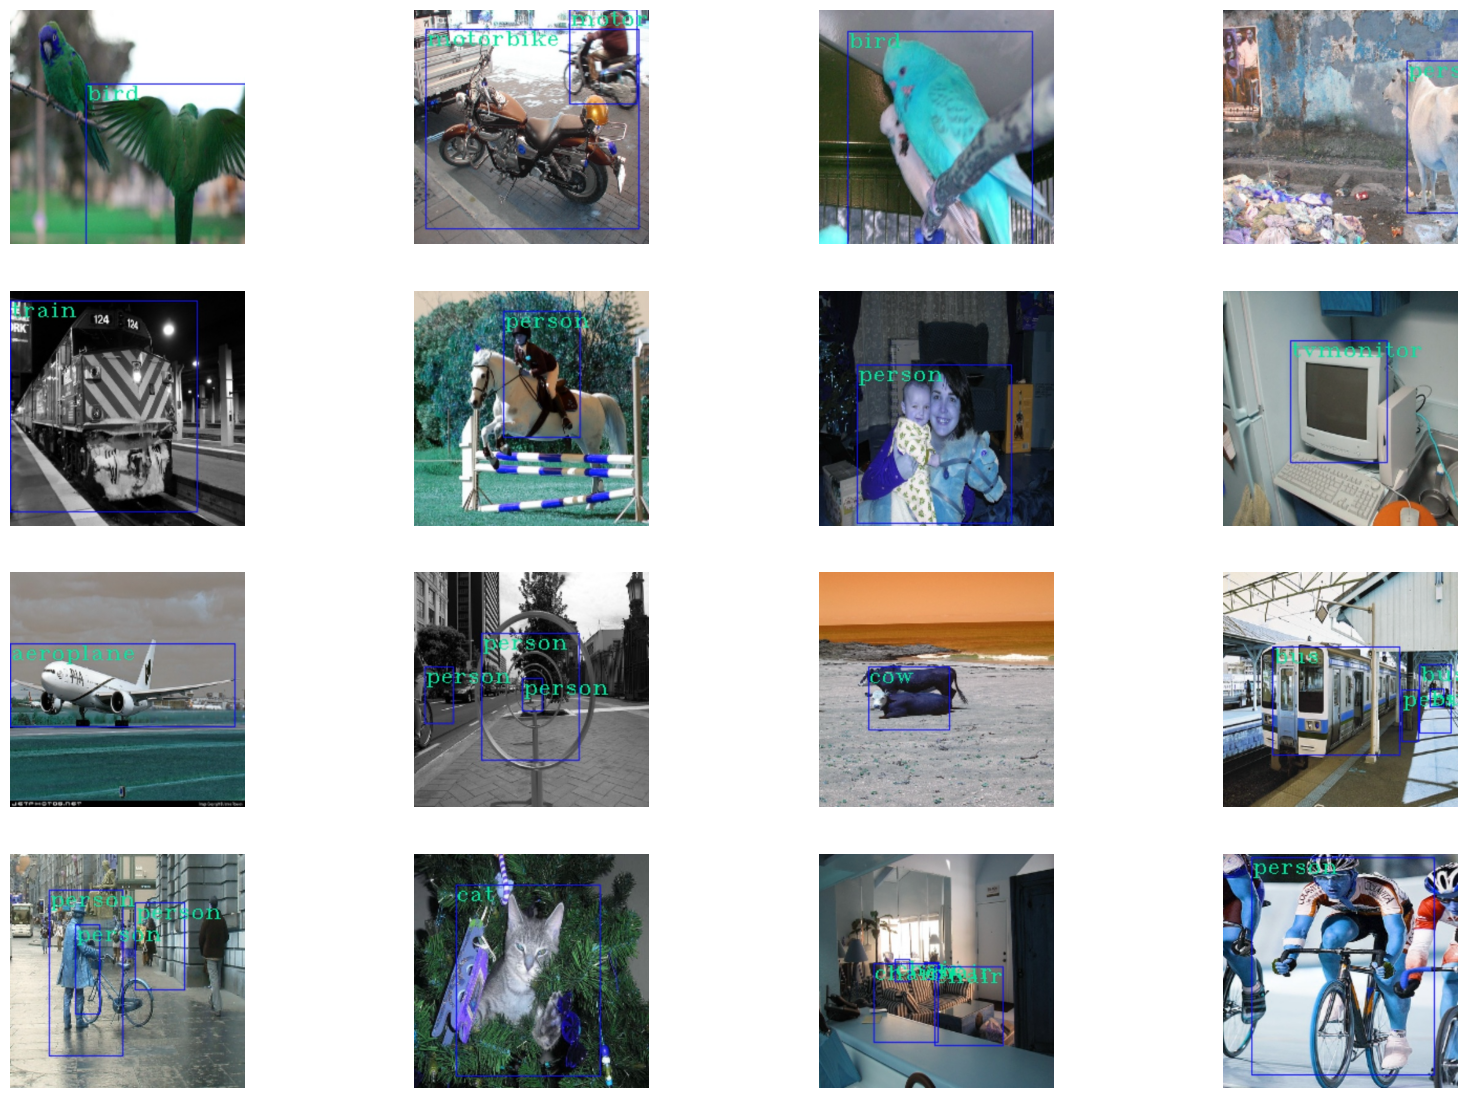

In [ ]:
plt.figure(figsize = (20,14))
for i, filename in enumerate(os.listdir(output)):
  img = cv2.imread(os.path.join(output, filename))
  ax = plt.subplot(4,4,i+1)
  plt.imshow(img)
  plt.axis('off')
  if i == 15:
    break